# Einführung in die Python Control Systems Library

LV Elektronische Steuerungs- und Regelungssysteme SS2020 (Master ETuIT, HSM, (c) Christoph Menz) 

***

Zur Lösung regelungstechnischer Problemstellungen mit Python bietet sich die Nutzung der [Python Control Systems Library](https://python-control.readthedocs.io/en/0.8.3/) an. Diese bietet ähnliche Funktionalitäten, wie die Matlab Control Systems Toolbox. Die Nutzung des vollständigen Funktionsumfangs erfordert unter Windows neben der [Installation der entsprechenden Library](https://python-control.readthedocs.io/en/0.8.3/intro.html) die zusätzliche Installation der Pakete
[NumPy+MKL](https://www.lfd.uci.edu/~gohlke/pythonlibs/#numpy)
sowie 
[SlyCot 0.3](https://www.lfd.uci.edu/~gohlke/pythonlibs/#slycot). 
([Installationsanleitung](https://tu-dresden.de/ing/elektrotechnik/rst/studium/python-in-der-lehre))

***

## Beispiel Gleichstrommotor

***

### Modellbildung Zustandsraum

Gegeben sei folgendes Modell eines Gleichstrommotors (vgl. Vorlesung - wir haben hier noch die Motorposition $\varphi = \int \omega dt$ als Zustandsgröße hinzugefügt):

$
\begin{align}
    \dot{\varphi} &= \omega \\
    \dot{\omega} &= -\frac{k_r}{J}\omega + \frac{k_m}{J}i - \frac{1}{J}M_L \\
    \dot{i} &= -\frac{k_m}{L}\omega -\frac{R}{L}i + \frac{1}{L}u_e \\
\end{align}
$

Mit dem Zustandsvektor 

$
\mathbf{x} = \begin{bmatrix}{ \varphi \\ \omega \\ i } \end{bmatrix} ,
$ 

der Systemmatrix

$
\mathbf{A} = 
\begin{bmatrix}
    0 & 1 & 0 \\ 
    0 & -\frac{k_r}{J} & \frac{k_m}{J} \\  
    0 & -\frac{k_m}{L} & - \frac{R}{L} 
\end{bmatrix} ,
$ 

dem Eingangsvektor 

$
\mathbf{u} = \begin{bmatrix}{ u_e \\ M_L} \end{bmatrix} ,
$ 

(Wir modellieren zunächst sowohl $u_e$ als auch $M_L$ als Eingänge des Systems. Damit lassen sich Störungen durch ein variierndes Lastmoment unkompliziert simulieren. Zum Entwurf des Reglers für den Motorbetrieb werden wir das Lastmoment später als Störgröße behandeln.)

und der zugehörigen Eingangsmatrix

$
\mathbf{B} = 
\begin{bmatrix}
    0 & 0 \\ 
    0 & -\frac{1}{J} \\  
    \frac{1}{L} & 0  
\end{bmatrix} 
$

können wir das System in eine Zustandsraumdarstellung der Form

$
\mathbf{\dot{x}} = \mathbf{Ax} + \mathbf{Bu}
$

überführen. 

Zu Simulationszwecken modellieren wir zunächst den kompletten Zustandsvektor als Ausgangsvektor. Es ergibt sich mit der Ausgangsmatrix

$
\mathbf{C} = 
\begin{bmatrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 1
\end{bmatrix} 
$

die Ausgangsgleichung

$
\mathbf{y} = \mathbf{C} \mathbf{x}
$


***

### Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
#plt.style.use('dark_background')

Wir nehmen an, dass die Parameter bereits identifizert wurden oder von vornherein bekannt sind:

In [2]:
# Parameter
R = 1
L = 0.01
J = 0.1
km = 1
kr = 1

# System
A = [[0.,1.,0.],[0,-kr/J,km/J],[0,-km/L,-R/L]]
B = [[0.,0.],[0,-1/J],[1/L,0]]
C = [[1,0,0],[0,1,0],[0,0,1]]
D = [[0,0],[0,0],[0,0]]

# Erzeugung eines ZR-Modells mit der Control Systemes Library
sys = ctrl.ss(A,B,C,D)

#### Sprungantwort 
(nur Spannungssprung, kein Lastmoment - nutzen wir das Moment als Eingang `input=1`, simulieren wir den Kurzschlussfall $u_e$ = 0):

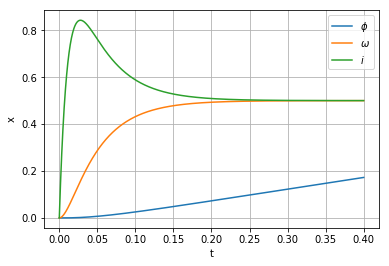

In [3]:
# Sprungantwort
t, y = ctrl.step_response(sys,T=np.linspace(0,0.4,1001),input=0)

plt.plot(t, y[0])
plt.plot(t, y[1])
plt.plot(t, y[2])
plt.grid()
plt.xlabel('t')
plt.ylabel('x')
plt.legend(['$\phi$','$\omega$','$i$'])
plt.show()

***

### Reglerentwurf

Ziel ist es zunächst, das System aktiv in der Nulllage $\varphi = 0$ zu halten.  

Unser System wird für den Entwurf auf eine Eingangsgröße $u = u_e$ und eine Ausgangsgröße $y = \varphi$ reduziert

$
\mathbf{b} = 
\begin{bmatrix}
    0 \\ 0 \\ \frac{1}{L}  
\end{bmatrix} 
$

$
\mathbf{c} = 
\begin{bmatrix}
    1 & 0 & 0  
\end{bmatrix} 
$

$
d = 0
$

In [4]:
# Erzeugung eines ZR-Modells mit der Control Systemes Library
b = [[0],[0],[1/L]]
c = [1,0,0]
d = 0

sysr = ctrl.ss(A,b,c,d)

Zunächst prüfen wir die Steuerbarkeit des Systems. Die Steuerbarkeitsmatrix muss den gleichen Rang, wie die Systemordnung - in unserem Fall 3 - haben:

In [5]:
# Steuerbarkeitsmatrix
Cm = ctrl.ctrb(A, b)
# Rang 
N = np.linalg.matrix_rank(Cm)

print("Rang = " + str(N)) 

Rang = 3


Jetzt können wir einen Regler mittels Polvorgabe entwerfen. Mit der linearen Zustandsrückführung $u = -\mathbf{k}^T\mathbf{x}$ ergibt sich das geregelte System 

$
\begin{align}
\mathbf{\dot{x}} 
&= \mathbf{A}\mathbf{x} + \mathbf{b} u \\  
&= \mathbf{A}\mathbf{x} - \mathbf{b} \mathbf{k}^T \mathbf{x} \\
&= \underbrace{(\mathbf{A} - \mathbf{b} \mathbf{k}^T)}_{\mathbf{A}_R} \mathbf{x} 
\end{align} 
$

Mit der Pol- oder Eigenwertvorgabe wird demzufolge die Dynamik des geregelten Systems 

$
\mathbf{\dot{x}} = \mathbf{A}_R \mathbf{x} \\
$

definiert. Zur Berechnung der Matrix $\mathbf{k}^T$ kann die Funktion `place` (oder `acker` für Eingrößensysteme) genutzt werden. Für ein stabiles Verhalten müssen die Eigenwerte einen negativen Realteil aufweisen.  

In [6]:
# Eigenwerte 
p = [-15,-30,-45]

# Reglermatrix
K = ctrl.place(A,b,p)

Q = np.diag([10,.1,.1])
R = np.diag([.01])

K1,S1,p1 = ctrl.lqr(A,b,Q,R)

print("k = " + str(K))
print("k1 = " + str(K1))
print("p1 = " + str(p1))

k = [[20.25   0.675 -0.2  ]]
k1 = [[31.6227766   2.39866175  2.38817537]]
p1 = [-328.44727 +0.j   -7.454327+0.j  -12.915936+0.j]


Wir können das Verhalten des geregelten Systems bei bestehender Anfangsabweichung mit der Funktion `forced_response` simulieren:

In [7]:
# geregeltes System
Ar = A - np.dot(b,K)
br = [[0],[0],[0]] 
cr = c
dr = d
sysr = ctrl.ss(Ar,br,cr,dr)

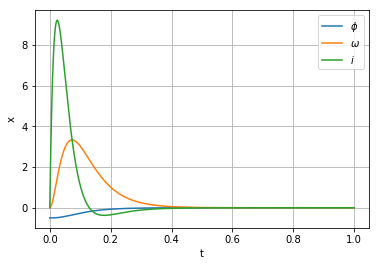

In [8]:
# Anfangszustand
x0 = [[-0.5],[0],[0]]

# Simulation
t, y, x= ctrl.forced_response(sysr,T=np.linspace(0,1.0,1001),X0=x0)

plt.plot(t, y)
plt.plot(t, x[1])
plt.plot(t, x[2])
plt.grid()
plt.xlabel('t')
plt.ylabel('x')
plt.legend(['$\phi$','$\omega$','$i$'])
plt.show()

Diese Art der Simulation ist für den ersten Entwurf und den Überblick über die gewünschte Dynamik geeignet. Um den zeitlichen Verlauf von Stellgrößen und ggf. weitere Störgrößen zu simulieren, ist es zweckmäßiger, das System explizit für definierte, ggf. diskrete Zeitschritte zu simulieren:


In [9]:
dt = 0.001 
T = np.arange(0,1+dt,dt) 

uc = np.zeros(len(T)) # Eingangsgröße 
xc = np.zeros([len(T)+1,3]) # Zustandsgrößen
yc = np.zeros(len(T)) # Ausgangsgröße

# Anfangsbedingung
x0 = [0.5,0,0]
xc[0] = np.array(x0)

for k in range(len(t)):
    
    # Stellgröße berechnen 
    uc[k] = - np.dot(K,xc[k])
    # System simulieren (Euler)
    dx = np.dot(A,xc[k]) + np.dot(b,uc[k]).T
    xc[k+1] = xc[k] + dx*dt
    # Ausgangsgröße
    yc[k] = np.dot(c,xc[k])

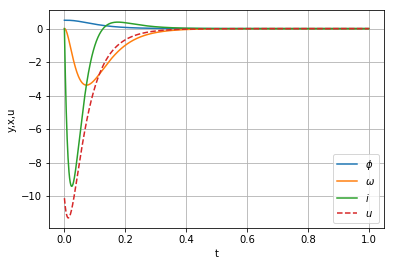

In [10]:
plt.plot(T, yc)
plt.plot(T, xc[:len(T),1])
plt.plot(T, xc[:len(T),2])
plt.plot(T, uc, '--')
plt.grid()
plt.xlabel('t')
plt.ylabel('y,x,u')
plt.legend(['$\phi$','$\omega$','$i$','$u$'])
plt.show()